# Comparing different atmospheric soundings <a class='tocSkip'></a>

Thomas Schanzer z5310829  
School of Physics, UNSW  
September 2021

Now that we have all the relevant functions ready in the $\verb |Environment|$ class, we will use them to compare several different atmospheric soundings:
- Sydney, Australia
- Singapore (humid)
- Abu Dhabi, United Arab Emirates (hot)
- Mawson, Antarctica (cold, dry)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducing-the-soundings" data-toc-modified-id="Introducing-the-soundings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introducing the soundings</a></span></li><li><span><a href="#Dry-regime" data-toc-modified-id="Dry-regime-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dry regime</a></span><ul class="toc-item"><li><span><a href="#Maximum-specific-humidity-increase" data-toc-modified-id="Maximum-specific-humidity-increase-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Maximum specific humidity increase</a></span></li><li><span><a href="#Neutral-buoyancy-level" data-toc-modified-id="Neutral-buoyancy-level-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Neutral buoyancy level</a></span></li><li><span><a href="#Parcel-motion" data-toc-modified-id="Parcel-motion-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Parcel motion</a></span></li></ul></li><li><span><a href="#Saturated-regime" data-toc-modified-id="Saturated-regime-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Saturated regime</a></span><ul class="toc-item"><li><span><a href="#Neutral-buoyancy-level" data-toc-modified-id="Neutral-buoyancy-level-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Neutral buoyancy level</a></span></li><li><span><a href="#Parcel-motion" data-toc-modified-id="Parcel-motion-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Parcel motion</a></span></li></ul></li><li><span><a href="#Limited-water-regime" data-toc-modified-id="Limited-water-regime-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Limited water regime</a></span><ul class="toc-item"><li><span><a href="#Neutral-buoyancy-level" data-toc-modified-id="Neutral-buoyancy-level-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Neutral buoyancy level</a></span></li><li><span><a href="#Parcel-motion" data-toc-modified-id="Parcel-motion-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Parcel motion</a></span></li></ul></li><li><span><a href="#Feedback-and-next-steps" data-toc-modified-id="Feedback-and-next-steps-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feedback and next steps</a></span></li></ul></div>

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
import metpy.constants as const
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT

from scipy.optimize import root_scalar

from os import mkdir
from os.path import exists
import sys
from types import MethodType

from environment import Environment
import environment

In [57]:
fig_path = ('20210922_sounding_comparisons_figures/')
if not exists(fig_path):
    mkdir(fig_path)

## Introducing the soundings

In [2]:
file = '../soundings/SYDNEY AIRPORT (94767) 12 Nov 2019 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
sydney = Environment(
    pressure, temperature, dewpoint,
    info='SYDNEY AIRPORT (94767) 12 Nov 2019 00Z', name='Sydney')

In [3]:
file = '../soundings/48698 WSSS Singapore Observations at 00Z 02 Sep 2021.txt'
sounding = pd.read_fwf(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=1)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
singapore = Environment(
    pressure, temperature, dewpoint,
    info='48698 WSSS Singapore Observations at 00Z 02 Sep 2021',
    name='Singapore')

In [4]:
file = ('../soundings/41217 OMAA Abu Dhabi Inter Arpt Observations at '
        '12Z 20 Sep 2021.txt')
sounding = pd.read_fwf(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=1)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
abu_dhabi = Environment(
    pressure, temperature, dewpoint,
    info='41217 OMAA Abu Dhabi Inter Arpt Observations at 12Z 20 Sep 2021',
    name='Abu Dhabi')

In [5]:
file = ('../soundings/89564 Mawson Observations at 12Z 21 Sep 2021.txt')
sounding = pd.read_fwf(
    file, names=['pressure', 'temperature', 'dewpoint'],
    usecols=[0, 2, 3], header=1)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
temperature = sounding[:,1]*units.celsius
dewpoint = sounding[:,2]*units.celsius
mawson = Environment(
    pressure, temperature, dewpoint,
    info='89564 Mawson Observations at 12Z 21 Sep 2021', name='Mawson')

In [41]:
# fixing a bug
def wetbulb_temperature(self, height):
    """
    Finds the environmental wet-bulb temperature at a given height.
    """

    pressure = self.pressure(height)
    temperature = self.temperature_from_pressure(pressure)
    dewpoint = self.dewpoint_from_pressure(pressure)
    wetbulb_temperature = mpcalc.wet_bulb_temperature(
        pressure, temperature, dewpoint)
    return wetbulb_temperature

for sounding in [sydney, singapore, abu_dhabi, mawson]:
    sounding.wetbulb_temperature = MethodType(wetbulb_temperature, sounding)

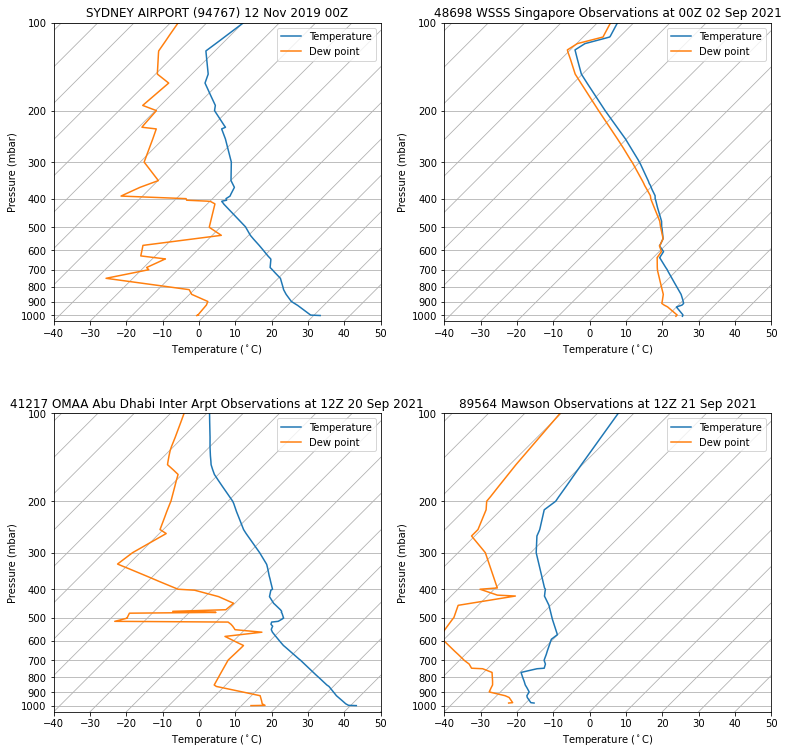

In [31]:
fig = plt.figure(figsize=(11,11))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    skew = SkewT(fig, subplot=(2,2,i+1), rotation=45)
    skew.plot(
        sounding.pressure_raw, sounding.temperature_raw, label='Temperature')
    skew.plot(sounding.pressure_raw, sounding.dewpoint_raw, label='Dew point')
    skew.ax.legend()
    skew.ax.set(
        xlabel=r'Temperature ($^\circ$C)',
        ylabel='Pressure (mbar)',
        title=sounding.info)

fig.tight_layout()
fig.savefig(
    fig_path + 'skew-t.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

## Dry regime
### Maximum specific humidity increase

In [32]:
height = np.arange(0, 10.1, 0.1)*units.km
max_dq = {}
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    max_dq[sounding.name] = sounding.maximum_specific_humidity_change(height)

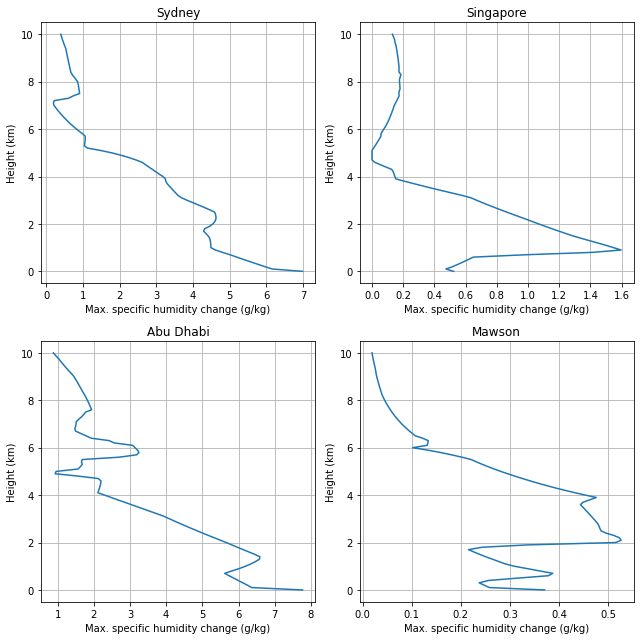

In [34]:
fig = plt.figure(figsize=(9,9))
for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(max_dq[sounding.name]*1e3, height)
    ax.set(
        xlabel='Max. specific humidity change (g/kg)',
        ylabel='Height (km)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.savefig(
    fig_path + 'max_dq.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()

### Neutral buoyancy level

In [19]:
height = np.arange(0, 10.01, 0.25)*units.km
dry_buoyancy_level = {}
dq = {}
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    print('Calculating for {}:'.format(sounding.name))
    max_max_dq = np.max(max_dq[sounding])
    dq[sounding] = np.arange(0, max_max_dq*1.001, max_max_dq/60 )
    dry_buoyancy_level[sounding] = sounding.dry_neutral_buoyancy_level(
        height, dq[sounding])

Calculating for Sydney:
Calculating buoyancy level 2501 of 2501.Calculating for Singapore:
Calculating buoyancy level 2501 of 2501.Calculating for Abu Dhabi:
Calculating buoyancy level 2501 of 2501.Calculating for Mawson:
Calculating buoyancy level 2501 of 2501.

KeyError: <environment.Environment object at 0x7fa6bee6f580>

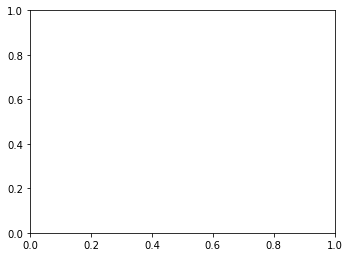

In [86]:
fig = plt.figure(figsize=(12,9))
height = np.arange(0, 10.01, 0.25)*units.km

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    mesh = ax.pcolormesh(
        dq[sounding]*1e3, height, dry_buoyancy_level[sounding],
        shading='nearest')
    cbar = plt.colorbar(mesh, extend='min')
    cbar.set_label('Neutral buoyancy level (km)')

    ax.plot(
        max_dq[sounding.name]*1e3, np.arange(0, 10.01, 0.1)*units.km,
        label='Maximum specific\nhumidity change', color='tab:orange')
    ax.legend()

    ax.set(
        xlabel='Specific humidity change (g/kg)',
        ylabel='Initial height (km)',
        title=sounding.name)
    ax.set_xlim(0, 7)

fig.tight_layout()
fig.savefig(
    fig_path + 'dry_neutral_buoyancy_level.png', dpi=300, facecolor='w',
    bbox_inches='tight')
plt.show()

### Parcel motion

In [66]:
dry_motion_3km = {}
initial_height = 3*units.km
initial_height_array = {}
dq = {}
time = np.arange(0, 1300, 20)*units.second
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    print('Calculating for {}:'.format(sounding.name))
    max_dq = sounding.maximum_specific_humidity_change(initial_height)
    dq[sounding.name] = np.arange(0, max_dq*1.001, max_dq/20)
    initial_height_array[sounding.name] = np.ones(
        len(dq[sounding.name]))*initial_height
    dry_motion_3km[sounding.name] = sounding.modified_motion(
        time, initial_height_array[sounding.name], dq[sounding.name],
        regime='dry')
    sys.stdout.write('\n')

Calculating for Sydney:
Calculating profile 21 of 21.   
Calculating for Singapore:
Calculating profile 21 of 21.   
Calculating for Abu Dhabi:
Calculating profile 8 of 21.   

/Users/tschanzer/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Calculating profile 15 of 21.   

/Users/tschanzer/anaconda3/lib/python3.8/site-packages/pint/quantity.py:1237: RuntimeWarning: divide by zero encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Calculating profile 18 of 21.   

/Users/tschanzer/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


Calculating profile 21 of 21.   

/Users/tschanzer/anaconda3/lib/python3.8/site-packages/pint/numpy_func.py:303: RuntimeWarning: overflow encountered in exp
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/Users/tschanzer/anaconda3/lib/python3.8/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)



Calculating for Mawson:
Calculating profile 21 of 21.   


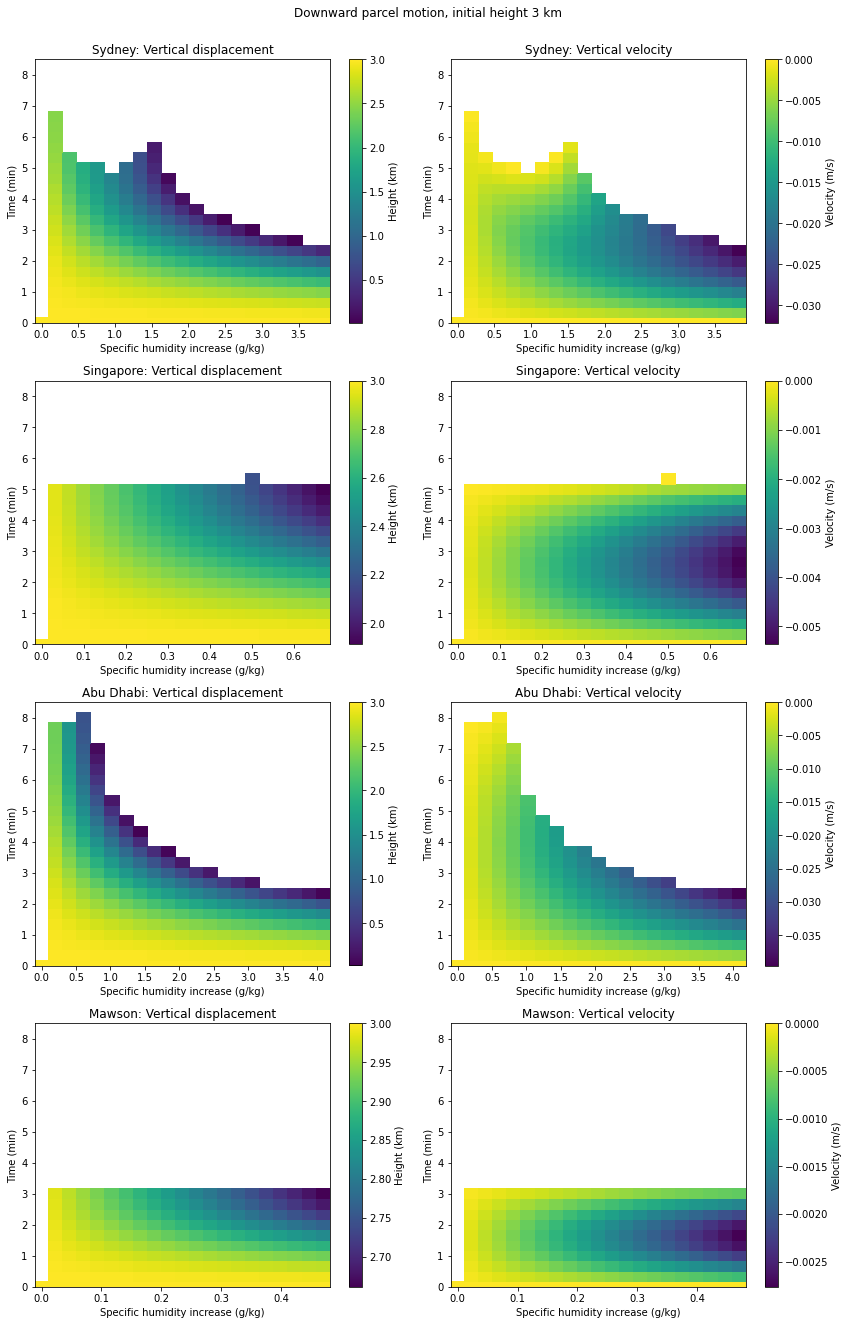

In [80]:
fig = plt.figure(figsize=(12,18))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax1 = fig.add_subplot(421+2*i)
    mesh = ax1.pcolormesh(
        dq[sounding.name]*1e3, time/60, 
        dry_motion_3km[sounding.name].height.T/1e3, shading='nearest')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Height (km)')
    ax1.set(
        xlabel='Specific humidity increase (g/kg)',
        ylabel='Time (min)',
        title='{}: Vertical displacement'.format(sounding.name))
    ax1.set_ylim(0, 8.5)

    ax2 = fig.add_subplot(422+2*i)
    mesh = ax2.pcolormesh(
        dq[sounding.name]*1e3, time/60, 
        dry_motion_3km[sounding.name].velocity.T/1e3, shading='nearest')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Velocity (m/s)')
    ax2.set(
        xlabel='Specific humidity increase (g/kg)',
        ylabel='Time (min)',
        title='{}: Vertical velocity'.format(sounding.name))
    ax2.set_ylim(0, 8.5)

fig.tight_layout()
fig.savefig(
    fig_path + 'dry_motion_3km.png', dpi=300, facecolor='w',
    bbox_inches='tight')
fig.suptitle('Downward parcel motion, initial height 3 km', y=1.02)
plt.show()

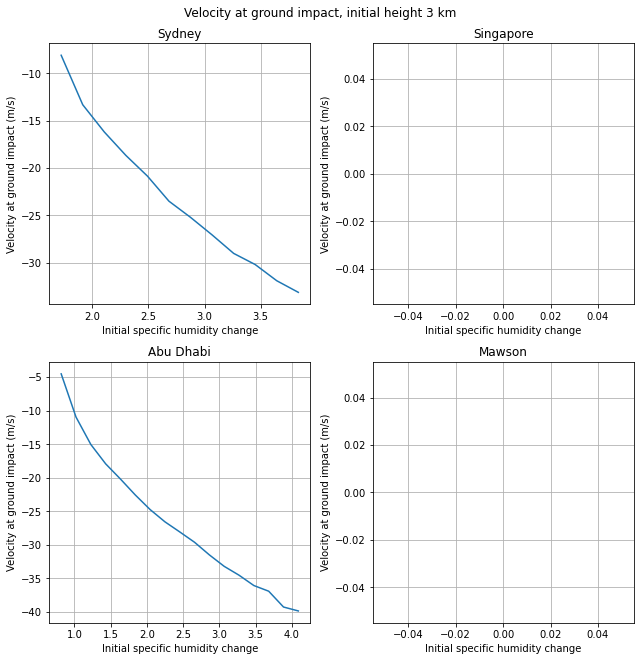

In [82]:
fig = plt.figure(figsize=(9,9))
height = np.arange(0, 10.01, 0.1)*units.km

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(
        dq[sounding.name]*1e3,
        dry_motion_3km[sounding.name].hit_ground_velocity)
    ax.set(
        xlabel='Initial specific humidity change',
        ylabel='Velocity at ground impact (m/s)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.savefig(
    fig_path + 'dry_ground_impact_velocity_3km.png', dpi=300, facecolor='w',
    bbox_inches='tight')
fig.suptitle('Velocity at ground impact, initial height 3 km', y=1.015)
plt.show()

## Saturated regime
### Neutral buoyancy level

In [43]:
height = np.arange(0, 10.01, 0.1)*units.km
saturated_buoyancy_level = {}
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    print('Calculating for {}:'.format(sounding.name))
    saturated_buoyancy_level[sounding.name] = \
        sounding.saturated_neutral_buoyancy_level(height)
    sys.stdout.write('\n')

Calculating for Sydney:
Calculating buoyancy level 101 of 101.
Calculating for Singapore:
Calculating buoyancy level 101 of 101.
Calculating for Abu Dhabi:
Calculating buoyancy level 101 of 101.
Calculating for Mawson:
Calculating buoyancy level 101 of 101.


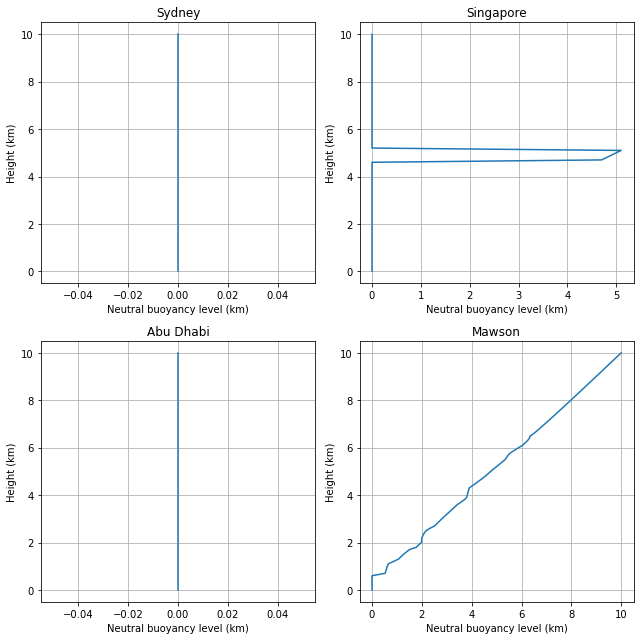

In [48]:
fig = plt.figure(figsize=(9,9))
height = np.arange(0, 10.01, 0.1)*units.km

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    ax.plot(saturated_buoyancy_level[sounding.name], height)
    ax.set(
        xlabel='Neutral buoyancy level (km)',
        ylabel='Height (km)',
        title=sounding.name)
    ax.grid()
fig.tight_layout()
fig.savefig(
    fig_path + 'saturated_neutral_buoyancy_level.png', dpi=300, facecolor='w',
    bbox_inches='tight')
plt.show()

### Parcel motion

In [72]:
saturated_motion = {}
initial_height = np.arange(0, 10.01, 0.5)*units.km
time = np.arange(0, 1300, 20)*units.second
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    print('Calculating for {}:'.format(sounding.name))
    saturated_motion[sounding.name] = sounding.modified_motion(
        time, initial_height, regime='saturated')
    sys.stdout.write('\n')

Calculating for Sydney:
Calculating profile 1 of 21.   

ValueError: setting an array element with a sequence.

## Limited water regime

In [59]:
# bug fix
def evaporation_level(
        initial_pressure, initial_temperature, initial_liquid_ratio):
    """
    Finds the pressure at which all liquid water evaporates.

    Args:
        initial_pressure: The initial pressure of the parcel.
        initial_temperature: The initial temperature of the parcel.
        initial_liquid_ratio: The ratio of the initial mass of liquid
            water to the total mass of the parcel.

    Returns:
        A tuple containing the pressure at which all liquid water
            evaporates, and the temperature of the parcel at this point.
    """

    initial_pressure = initial_pressure.to(units.mbar).m
    initial_temperature = initial_temperature.to(units.celsius).m

    solution = root_scalar(
        environment.remaining_liquid_ratio,
        args=(initial_pressure, initial_temperature, initial_liquid_ratio),
        bracket=[initial_pressure, 2000])
    level = solution.root*units.mbar

    if initial_liquid_ratio != 0:  # EL is below initial level
        level_temperature = mpcalc.moist_lapse(
            level, initial_temperature*units.celsius,
            reference_pressure=initial_pressure*units.mbar)
    else:  # EL is at initial level
        level_temperature = initial_temperature*units.celsius

    return level, level_temperature
environment.evaporation_level = evaporation_level

### Neutral buoyancy level

In [75]:
height = np.arange(0, 10.01, 0.5)*units.km
liquid_ratio = np.arange(0, 5e-3, 0.25e-3)
limited_buoyancy_level = {}
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    print('Calculating for {}:'.format(sounding.name))
    limited_buoyancy_level[sounding.name] = \
        sounding.limited_neutral_buoyancy_level(height, liquid_ratio)

Calculating for Sydney:
Calculating buoyancy level 420 of 420.Calculating for Singapore:
Calculating buoyancy level 183 of 420.

KeyboardInterrupt: 

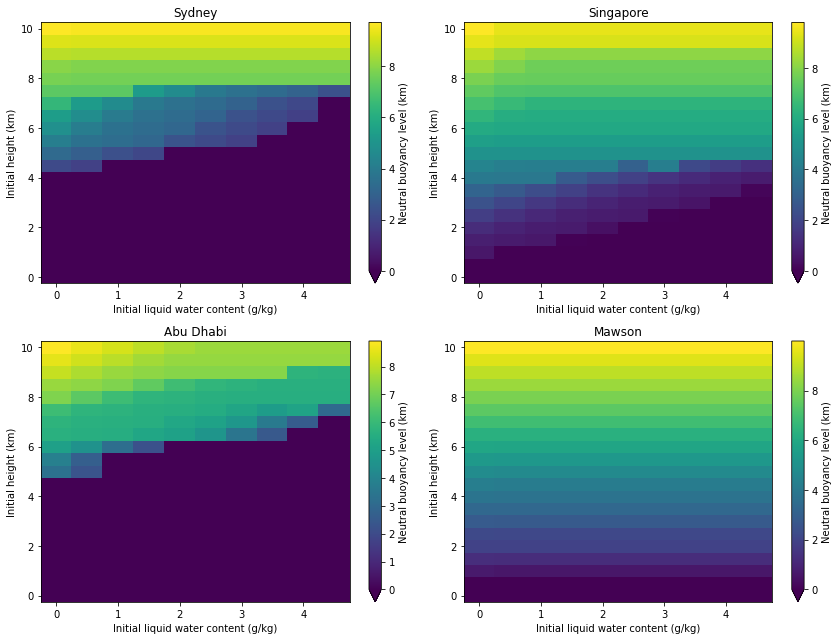

In [64]:
fig = plt.figure(figsize=(12,9))

for i, sounding in enumerate([sydney, singapore, abu_dhabi, mawson]):
    ax = fig.add_subplot(221+i)
    mesh = ax.pcolormesh(
        liquid_ratio*1e3, height, limited_buoyancy_level[sounding.name],
        shading='nearest')
    cbar = plt.colorbar(mesh, extend='min')
    cbar.set_label('Neutral buoyancy level (km)')

    ax.set(
        xlabel='Initial liquid water content (g/kg)',
        ylabel='Initial height (km)',
        title=sounding.name)

fig.tight_layout()
fig.savefig(
    fig_path + 'limited_neutral_buoyancy_level.png', dpi=300, facecolor='w',
    bbox_inches='tight')
plt.show()

### Parcel motion

In [74]:
limited_motion_3km = {}
liquid_ratio = np.arange(0, 5.01e-3, 0.5e-3)
initial_height = np.ones(len(liquid_ratio))*3*units.km
time = np.arange(0, 1300, 20)*units.second
for sounding in [sydney, singapore, abu_dhabi, mawson]:
    print('Calculating for {}:'.format(sounding.name))
    limited_motion_3km[sounding.name] = sounding.modified_motion(
        time, initial_height, liquid_ratio,
        regime='limited')
    sys.stdout.write('\n')

Calculating for Sydney:
Calculating profile 1 of 11.   

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1

## Feedback and next steps

- Debug parcel motion functions for saturated and limited water regimes
- Give parcel downward nudge without evaporation to determine stability, ~1m/s
- Account for mass of liquid water when calculating density
- Model entrainment
- Presentation to group next Thursday